# 0 Configuration

In [1]:
config= {
    "data_loading_disparate": {
        "loading": True,
        "study": True,
        "merging": True,
        "saving": True
    },
    "overview": {
        "overview_plot": True
    },
    "cleaning": {
        "global": {
            "usability": {
                "id_features_retrieval": True,
                "drop": False
            },
        },
        "categoricals": {
            "overview": {
                "describe": True
            }
        },
        "numericals": {
            "overview": {
                "describe": True,
                "plot": False
            },
            "correlations": {
                "overview_heatmap_plot": True
            },
            "outliers": {
                "analyse": True,
                "remove": False
            }
        },
        "datetimes": {
            "overview": {
                "describe": True,
                "plot": True
            }
        }
    }
}

***
# 1 Dependencies import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil
from datetime import datetime

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

In [3]:
def dataframe_distribution_overview(data, figsize=(10, 3)):
    plt.figure(figsize=figsize)

    sns.barplot(x=data.columns, y=data.count())

    plt.title("Number of values per column", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.ylabel("Number values", size=16)
    plt.show()

In [4]:
def index_lth(data, percentage: int):
    percentage = percentage / 100
    less_than = data.count() < data.shape[0] * percentage
    index_less_than = less_than[less_than == True].index
    return index_less_than

In [5]:
def multi_plot_numerical(data, features, kind="hist", n_cols=8, figsize=(30, 10), wspace=0.35, hspace=0.35):
    feature_nb = len(features)
    n_rows = ceil(feature_nb / n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for r in range(n_rows):
        for c in range(n_cols):
            if index >= feature_nb:
                break

            plt.subplot(n_rows, n_cols, index+1)

            feature = features[index]

            if kind == "box":
                plot = sns.boxplot(y=data[feature])
            elif kind == "hist":
                plot = sns.histplot(data=data[feature], kde=True)
            else:
                plot = sns.histplot(data=data[feature], kde=True)

            plot.set_xlabel(feature, fontsize=12)
            plot.set_ylabel(None)

            index += 1

    plt.show()

In [6]:
def create_subplot(dataset, feature, n_rows, index, is_numeric):
    plt.subplot(n_rows, 2, index)
    uniques = dataset[feature].unique()

    if is_numeric:
        plot = sns.boxplot(y=dataset[feature])
    else:
        if uniques.size <= 20 and uniques.size > 0:
            plot = sns.countplot(x=dataset[feature])
            plt.xticks(rotation=45, size=8, ha="right")
        else:
            dist = pd.DataFrame(data=[[uniques.size, dataset.shape[0] - uniques.size]], columns=["uniques", "not_uniques"])
            plot = sns.barplot(data=dist)

    plot.set_xlabel(None)
    plot.set_ylabel(feature, fontsize=14)


def dataset_diff_analysis(data1, data2, exclude=[], figsize=(15, 200)):
    features = data1.columns.union(data2.columns).difference(exclude)
    n_cols = 2
    n_rows = len(features)
    col_id = 0
    index = 1

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.35, hspace=0.5)

    for f in features:
        is_numeric = False
        if f in data1.columns:
            f_type = data1[f].dtype
        else:
            f_type = data2[f].dtype
        if f_type in ["int64", "float64"]:
            is_numeric = True

        if f in data1.columns.values:
            create_subplot(data1, f, n_rows, index, is_numeric)
        if f in data2.columns.values:
            create_subplot(data2, f, n_rows, index+1, is_numeric)

        index += 2

    print(f"features: {features}")
    plt.show()

In [7]:
def decribe_several(feature, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.describe()

In [8]:
def head_several(feature, nb, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.head(nb)

In [9]:
class OutlierProcessor():
    def __init__(self, data, features, lower_trig, upper_trig):
        self.data = data
        self.features = features
        self.lower_trig = lower_trig
        self.upper_trig = upper_trig
        self.__above = 0
        self.__below = 0
        self.__total = 0

    def __print(self):
        print(f"lower_trig: {self.lower_trig}")
        print(f"upper_trig: {self.upper_trig}")
        print(f"below: {self.__below}")
        print(f"above: {self.__above}")
        print(f"total: {self.__total}")

    def analyse(self):
        self.__below = self.data[self.data[self.features] < self.lower_trig][self.features].count()
        self.__above = self.data[self.data[self.features] > self.upper_trig][self.features].count()
        self.__total = self.__below + self.__above
        self.__print()

    def replace(self, replace_by=np.nan, inplace=False):
        result = self.data.loc[:, self.features].where(cond=lambda x: ((x > self.lower_trig) & (self.upper_trig > x)), other=replace_by)
        if inplace:
            self.data[self.features] = result
        else:
            return result

In [10]:
class OutlierIqrProcessor(OutlierProcessor):
    def __init__(self, data, features, exclude=[]):
        self.features = [feature for feature in features if feature not in exclude]
        self.__q1 = data[self.features].quantile(0.25)
        self.__q3 = data[self.features].quantile(0.75)
        self.__iqr = self.__q3 - self.__q1
        upper_trig = self.__q3 + (1.5 * self.__iqr)
        lower_trig = self.__q1 - (1.5 * self.__iqr)
        super().__init__(data, self.features, lower_trig, upper_trig)

In [11]:
def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

In [12]:
def unique_several(dataset, features, take=20):
    uniques_data = {}
    too_many_uniques = []
    only_one_uniques = []
    only_two_uniques = []

    for f in features:
        f_uniques = dataset[f].unique()
        if f_uniques.size <= take:
            if f_uniques.size == 1:
                only_one_uniques.append(f)
            elif f_uniques.size == 2:
                only_two_uniques.append(f)
            else:
                uniques_data[f] = pd.Series(data=f_uniques, name=f, dtype="object")
        else:
            too_many_uniques.append((f, f_uniques.size))

    print(f"Only one unique: {only_one_uniques}")
    print(f"Only two uniques: {only_two_uniques}")
    print(f"Too many uniques: {too_many_uniques}")

    return pd.DataFrame(data=uniques_data)

In [13]:
def strip_and_lower(dataset, features, to_strip=None, inplace=False):
    result_data = {}
    for f in features:
        result_data[f] = pd.Series(data=dataset[f].str.strip(to_strip=to_strip), name=f, dtype="object")
        result_data[f] = result_data[f].str.lower()
    result = pd.DataFrame(data=result_data)
    if inplace:
        dataset[features] = result
    else:
        return result

In [14]:
def fuzzy_matching_several(dataset, fuzzy, limit=10):
    fuzzy_data = {}
    for feature, match in fuzzy:
        fuzzy_matches = fuzzywuzzy.process.extract(match, dataset[feature], limit=limit, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        fuzzy_data[feature] = pd.Series(data=fuzzy_matches, name=feature, dtype="object")
    return pd.DataFrame(data=fuzzy_data)

In [15]:
def feature_distribution_multivar(data, features, figsize=(10, 3), wspace=0.2, hspace=0.2, corr_scale=(0.75, 0), xlim=(None, None), ylim=(None, None)):
    plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    plt.subplot(1, 2, 1)
    for f in features:
        plot = sns.kdeplot(data=data[f], label=f, shade=True)

    plt.title(f"Distribution", size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(None)
    plt.ylabel("Density", size=16)
    plt.legend()

    plt.subplot(1, 2, 2)
    correlation = data.loc[:, features].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=corr_scale[0], center=corr_scale[1],
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f"Correlation", size=20)
    plt.xticks(rotation=45, size=12, ha="right")
    plt.yticks(rotation=0, size=12, va="center")
    
    plt.show()

In [16]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values

In [17]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [18]:
def get_datetime_features_name(dataset):
    features_name = dataset.select_dtypes(["datetime64"]).columns.values.tolist()
    return features_name

***
# 2 Data Loading disparate

## 2.1 Loading

In [19]:
if config["data_loading_disparate"]["loading"]:
    customers = pd.read_csv("data/olist_customers_dataset.csv", delimiter=",")
    geoloc = pd.read_csv("data/olist_geolocation_dataset.csv", delimiter=",")
    items = pd.read_csv("data/olist_order_items_dataset.csv", delimiter=",")
    payments = pd.read_csv("data/olist_order_payments_dataset.csv", delimiter=",")
    reviews = pd.read_csv("data/olist_order_reviews_dataset.csv", delimiter=",")
    orders = pd.read_csv("data/olist_orders_dataset.csv", delimiter=",")
    products = pd.read_csv("data/olist_products_dataset.csv", delimiter=",")
    sellers = pd.read_csv("data/olist_sellers_dataset.csv", delimiter=",")
    category = pd.read_csv("data/product_category_name_translation.csv", delimiter=",")

***
## 2.2 Overview

### 2.2.1 Customers

In [20]:
if config["data_loading_disparate"]["study"]:
    customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [21]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [22]:
if config["data_loading_disparate"]["study"]:
    customers.describe(include="all")

In [23]:
if config["data_loading_disparate"]["study"]:
    customers.drop_duplicates(subset=["customer_unique_id"], inplace=True)
    # customers.rename(columns={"customer_zip_code_prefix": "zip_code_prefix", "customer_city": "city", "customer_state": "state"}, inplace=True)

In [24]:
if config["data_loading_disparate"]["study"]:
    customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               96096 non-null  object
 1   customer_unique_id        96096 non-null  object
 2   customer_zip_code_prefix  96096 non-null  int64 
 3   customer_city             96096 non-null  object
 4   customer_state            96096 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.4+ MB


***
### 2.2.2 Geolocation

In [25]:
if config["data_loading_disparate"]["study"]:
    geoloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [26]:
if config["data_loading_disparate"]["study"]:
    geoloc.describe(include="all")

In [27]:
if config["data_loading_disparate"]["study"]:
    geoloc.drop_duplicates(subset=["geolocation_lat", "geolocation_lng"], inplace=True)
    # geoloc.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix", "geolocation_city": "city", "geolocation_state": "state"}, inplace=True)

In [28]:
if config["data_loading_disparate"]["study"]:
    geoloc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718463 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  718463 non-null  int64  
 1   geolocation_lat              718463 non-null  float64
 2   geolocation_lng              718463 non-null  float64
 3   geolocation_city             718463 non-null  object 
 4   geolocation_state            718463 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 32.9+ MB


***
### 2.2.3 Items

In [29]:
if config["data_loading_disparate"]["study"]:
    items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [30]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [31]:
if config["data_loading_disparate"]["study"]:
    items.describe(include="all")

In [32]:
# if config["data_loading_disparate"]["study"]:
#     items.drop_duplicates(subset=["order_id"], inplace=True)

In [33]:
if config["data_loading_disparate"]["study"]:
    items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


***
### 2.2.4 Payments

In [34]:
if config["data_loading_disparate"]["study"]:
    payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [35]:
if config["data_loading_disparate"]["study"]:
    payments.describe(include="all")

In [36]:
if config["data_loading_disparate"]["study"]:
    payments.drop_duplicates(subset=["order_id"], inplace=True)

In [37]:
if config["data_loading_disparate"]["study"]:
    payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99440 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              99440 non-null  object 
 1   payment_sequential    99440 non-null  int64  
 2   payment_type          99440 non-null  object 
 3   payment_installments  99440 non-null  int64  
 4   payment_value         99440 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.6+ MB


***
### 2.2.5 Reviews

In [38]:
if config["data_loading_disparate"]["study"]:
    reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [39]:
if config["data_loading_disparate"]["study"]:
    reviews.describe(include="all")

In [40]:
if config["data_loading_disparate"]["study"]:
    reviews.drop_duplicates(subset=["order_id"], inplace=True)

In [41]:
if config["data_loading_disparate"]["study"]:
    reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98673 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                98673 non-null  object
 1   order_id                 98673 non-null  object
 2   review_score             98673 non-null  int64 
 3   review_comment_title     11551 non-null  object
 4   review_comment_message   40785 non-null  object
 5   review_creation_date     98673 non-null  object
 6   review_answer_timestamp  98673 non-null  object
dtypes: int64(1), object(6)
memory usage: 6.0+ MB


***
### 2.2.6 Orders

In [42]:
if config["data_loading_disparate"]["study"]:
    orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [43]:
if config["data_loading_disparate"]["study"]:
    orders.describe(include="all")

In [44]:
# if config["data_loading_disparate"]["study"]:
#     orders.drop_duplicates(subset=["order_id"], inplace=True)

In [45]:
if config["data_loading_disparate"]["study"]:
    orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


***
### 2.2.7 Products

In [46]:
if config["data_loading_disparate"]["study"]:
    products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [47]:
if config["data_loading_disparate"]["study"]:
    products.describe(include="all")

In [48]:
if config["data_loading_disparate"]["study"]:
    products.drop_duplicates(subset=["product_id"], inplace=True)

In [49]:
if config["data_loading_disparate"]["study"]:
    products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


***
### 2.2.8 Sellers

In [50]:
if config["data_loading_disparate"]["study"]:
    sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [51]:
if config["data_loading_disparate"]["study"]:
    sellers.describe(include="all")

In [52]:
if config["data_loading_disparate"]["study"]:
    sellers.drop_duplicates(subset=["seller_id"], inplace=True)

In [53]:
if config["data_loading_disparate"]["study"]:
    sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 120.9+ KB


***
### 2.2.9 Category

In [54]:
if config["data_loading_disparate"]["study"]:
    category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [55]:
if config["data_loading_disparate"]["study"]:
    category.describe(include="all")

In [56]:
if config["data_loading_disparate"]["study"]:
    category.drop_duplicates(inplace=True)

In [57]:
if config["data_loading_disparate"]["study"]:
    category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


***
## 2.3 Merging

In [58]:
if config["data_loading_disparate"]["merging"]:
    data = orders.merge(customers, how="left", on="customer_id")
    data = data.merge(reviews, on="order_id")
    data = data.merge(payments, on="order_id")
    data = data.merge(items, on="order_id")
    data = data.merge(products, on="product_id")
    data = data.merge(sellers, on="seller_id")

    # data = data.merge(geoloc, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", suffixes=("", "_ customer"))
    # data = data.merge(geoloc, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", suffixes=("", "_seller"))

    data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111705 entries, 0 to 111704
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111705 non-null  object 
 1   customer_id                    111705 non-null  object 
 2   order_status                   111705 non-null  object 
 3   order_purchase_timestamp       111705 non-null  object 
 4   order_approved_at              111690 non-null  object 
 5   order_delivered_carrier_date   110530 non-null  object 
 6   order_delivered_customer_date  109366 non-null  object 
 7   order_estimated_delivery_date  111705 non-null  object 
 8   customer_unique_id             107697 non-null  object 
 9   customer_zip_code_prefix       107697 non-null  float64
 10  customer_city                  107697 non-null  object 
 11  customer_state                 107697 non-null  object 
 12  review_id                     

In [59]:
if config["data_loading_disparate"]["merging"] and False:
    data = data.merge(geoloc, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", suffixes=("_customer", "_customer"))

    data.info()

In [60]:
if config["data_loading_disparate"]["merging"] and False:
    data = data.merge(geoloc, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", suffixes=("_seller", "_seller"))

    data.info()

***
## 2.4 Saving

In [61]:
if config["data_loading_disparate"]["saving"]:
    data.to_csv("data/data_merged.csv", sep=",", index=False)

***
# 3 Data loading merged

In [62]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [63]:
data = pd.read_csv("data/data_merged.csv", delimiter=",")

In [64]:
# data = pd.read_csv("data/data_merged.csv", delimiter=",", parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "review_creation_date", "review_answer_timestamp", "shipping_limit_date"])

In [65]:
categ_cols = get_categorical_features_name(data, split_by_unique_count=False)
num_cols = get_numerical_features_name(data)
datetime_cols = get_datetime_features_name(data)

***
# 4 Overview

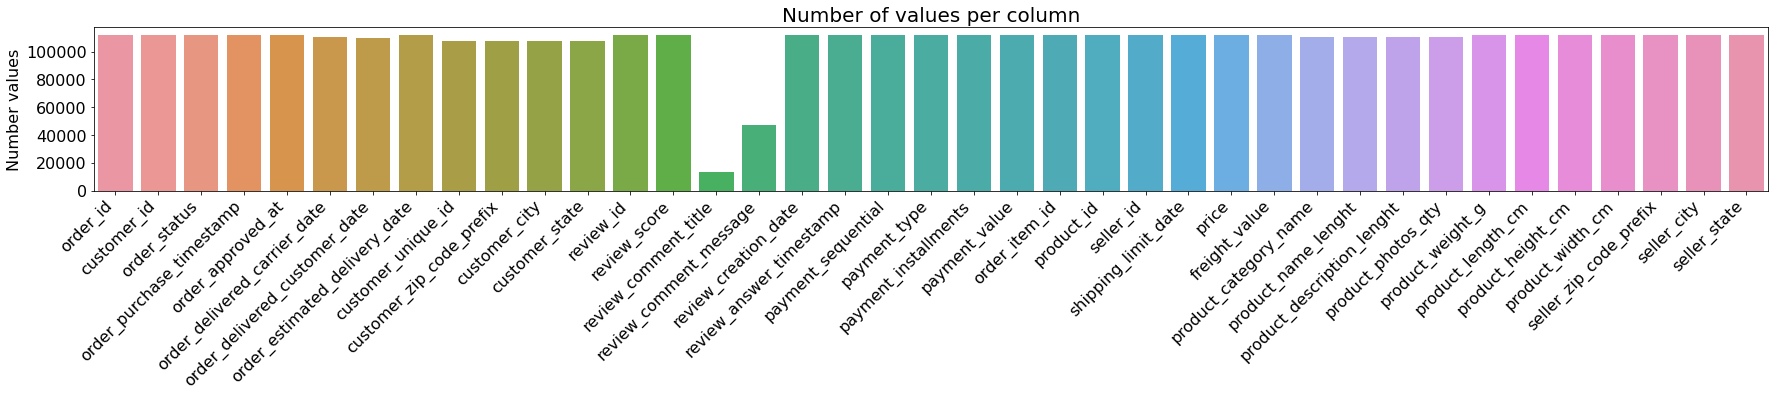

In [66]:
if config["overview"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

***
# 5 Cleaning

## 5.1 Global

### 5.1.1 Usability

In [67]:
if config["cleaning"]["global"]["usability"]["id_features_retrieval"]:
    id_features = data.columns[data.columns.str.endswith("_id")]
    id_features

In [68]:
if config["cleaning"]["global"]["usability"]["drop"]:
    features_to_delete = id_features
    data.drop(columns=features_to_delete, inplace=True)

In [69]:
categ_cols = get_categorical_features_name(data, split_by_unique_count=False)
num_cols = get_numerical_features_name(data)

***
## 5.2 Categoricals

### 5.2.1 Overview

In [70]:
if config["cleaning"]["categoricals"]["overview"]["describe"]:
    data[categ_cols].describe()

***
### 5.2.2 Inconsistencies

In [71]:
unique_several(data, data[categ_cols], take=50)

Only one unique: []
Only two uniques: []
Too many uniques: [('order_id', 97916), ('customer_id', 97916), ('order_purchase_timestamp', 97370), ('order_approved_at', 89534), ('order_delivered_carrier_date', 80450), ('order_delivered_customer_date', 95022), ('order_estimated_delivery_date', 449), ('customer_unique_id', 94656), ('customer_city', 4108), ('review_id', 97454), ('review_comment_title', 4496), ('review_comment_message', 35619), ('review_creation_date', 632), ('review_answer_timestamp', 97292), ('product_id', 32789), ('seller_id', 3090), ('shipping_limit_date', 92642), ('product_category_name', 74), ('seller_city', 611)]


,order_status,customer_state,payment_type,seller_state
0,delivered,SP,credit_card,SP
1,shipped,SC,boleto,RJ
2,canceled,PR,voucher,MG
3,invoiced,RJ,debit_card,ES
4,processing,MG,NaN,RS
5,unavailable,RS,NaN,DF
6,approved,NaN,NaN,PR
7,NaN,AM,NaN,SC
8,NaN,BA,NaN,GO
9,NaN,GO,NaN,BA


***
## 5.3 Numericals

### 5.3.1 Overview

In [72]:
if config["cleaning"]["numericals"]["overview"]["describe"]:
    data[num_cols].describe()

In [73]:
if config["cleaning"]["numericals"]["overview"]["plot"]:
    multi_plot_numerical(data, num_cols, n_cols=5, hspace=0.4, wspace=0.2, figsize=(30, 30))

***
### 5.3.3 Correlations

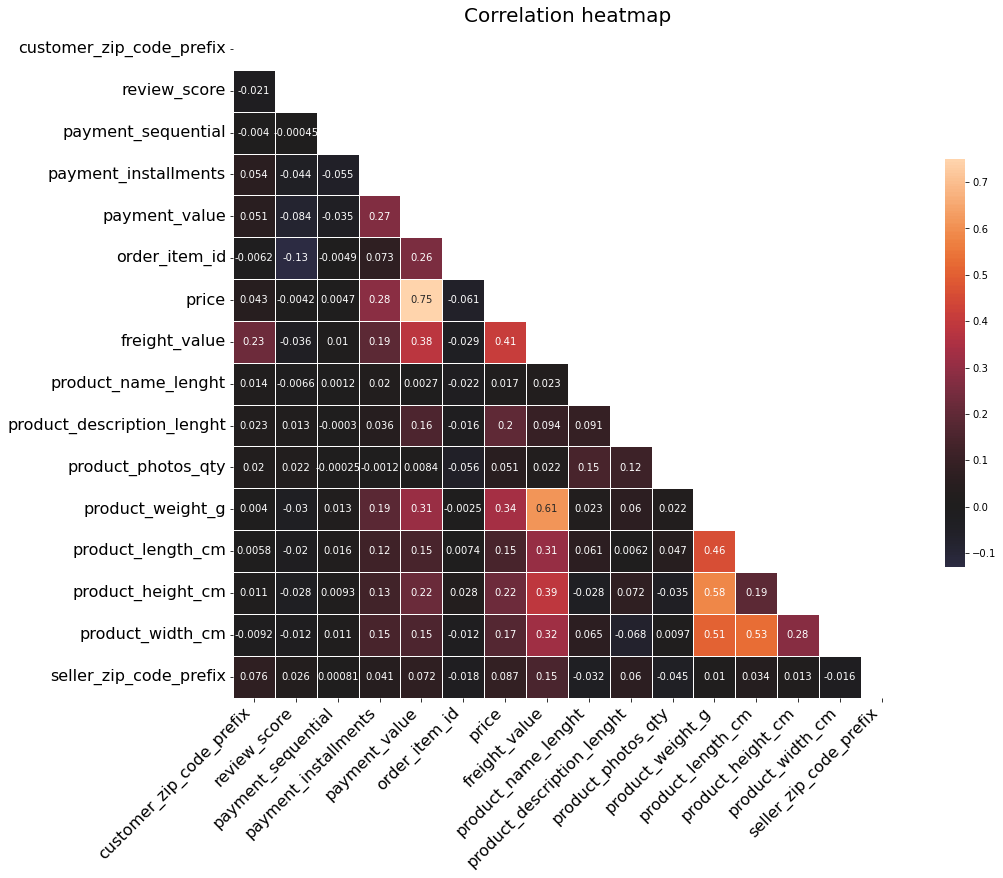

In [74]:
if config["cleaning"]["numericals"]["correlations"]["overview_heatmap_plot"]:
    correlation_heatmap(data[num_cols], figsize=(15, 15))

***
### 5.3.4 Outliers

In [75]:
if config["cleaning"]["numericals"]["outliers"]["analyse"]:
    outlier_proc = OutlierIqrProcessor(data, data[num_cols], exclude=["customer_zip_code_prefix", "review_score", "payment_sequential", "payment_installments"])
    outlier_proc.analyse()

lower_trig: payment_value                  -129.955
order_item_id                     1.000
price                          -102.600
freight_value                     0.975
product_name_lenght              19.500
product_description_lenght     -609.000
product_photos_qty               -2.000
product_weight_g              -1950.000
product_length_cm               -12.000
product_height_cm               -10.000
product_width_cm                 -7.500
seller_zip_code_prefix       -25980.000
dtype: float64
upper_trig: payment_value                   387.285
order_item_id                     1.000
price                           277.400
freight_value                    33.255
product_name_lenght              79.500
product_description_lenght     1943.000
product_photos_qty                6.000
product_weight_g               4050.000
product_length_cm                68.000
product_height_cm                38.000
product_width_cm                 52.500
seller_zip_code_prefix        60444.000
d

In [76]:
if config["cleaning"]["numericals"]["outliers"]["analyse"] and config["cleaning"]["numericals"]["outliers"]["remove"]:
    outlier_proc.replace(inplace=True)

***
## 5.4 Datetimes

### 5.4.1 Overview

In [77]:
if config["cleaning"]["datetimes"]["overview"]["describe"]:
    pass
# data[datetime_cols].describe(datetime_is_numeric=True)

In [78]:
for col in datetime_cols:
    data[col] = data[col].astype("object")
    data[col] = pd.to_datetime(data[col], format="%Y-%m-%d %H:%M:%S")

In [79]:
if config["cleaning"]["datetimes"]["overview"]["describe"]:
    pass
# data[datetime_cols].describe(datetime_is_numeric=True)

In [80]:
if config["cleaning"]["datetimes"]["overview"]["plot"]:
    pass

***
# X Saving

In [81]:
data.to_csv("data/data_cleaned.csv", sep=",", index=False)